In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as st

sn.set(font_scale=1.4)#for label size

from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
count = {"AllAI":100, "AllRnd":100, "RndandAI":100}
typename = {"AllAI":"All AI Players", "AllRnd":"Random Players", "RndandAI":"One AI, Rest Random Players"}
nump = {"Agram":4, "Pairs":2, "NinetyEight":4}
convergence = {}
heuristics = {}
game = "NinetyEight"
tricktaking = False

In [3]:
w = 0.4
tricks = 6
epoch = 10
for type in count.keys():
    if tricktaking:
        fopen = open("../CardStockXam/bin/Release/games/" + game + str(4) + ".gdl" + type + "-choicestats.txt")
        data = fopen.readlines()
        fopen.close()
        nump = 4
        lead = np.zeros(tricks)
        follow = np.zeros(tricks)
        followerr = np.zeros(tricks)
        followall = [[], [], [], [], [], []]
        for i in range(2, len(data[1:302]), 3):
            choices = [int(x) for x in data[i][:-2].strip().split(",")]
            for j in range(len(choices)):
                if (j % nump == 0):
                    lead[j // 4] += choices[j] / count[type]
                else:
                    follow[j // 4] += choices[j] / ((nump - 1) * count[type])
                    followall[j // 4].append(choices[j])
        for i in range(tricks):
            vals = []
            for j in range(epoch):
                x = sum(followall[i][epoch*j:epoch*(j+1)]) / (count[type]/epoch)
                vals.append(x)
            followerr[i] = np.std(vals)
        ax = plt.figure(figsize=(10,5)).gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.bar([x - w/2 for x in range(1, len(lead)+1)], lead, width=w)
        plt.bar([x + w/2 for x in range(1, len(follow) + 1)], follow, width=w, color="r")
        plt.errorbar([x + w/2 for x in range(1, len(follow) + 1)], follow, yerr=followerr, fmt='none', capsize=4, color="k")
        plt.xlabel("Trick")
        plt.ylabel("Branching Factor")
        plt.legend(["Lead", "Others"])
        plt.title(game + ": " + typename[type])

In [4]:
for type in count.keys():
    if tricktaking:
        fopen = open("../CardStockXam/bin/Release/games/" + game + str(4) + ".gdl" + type + "-choicestats.txt")
        data = fopen.readlines()
        fopen.close()
        nump = 4
        everychoice = np.zeros(tricks * nump)
        for i in range(2, len(data[1:302]), 3):
            choices = [int(x) for x in data[i][:-2].strip().split(",")]
            slope, intercept, r_value, p_value, std_error = st.linregress(range(1, len(choices) + 1), choices)
            for j in range(len(choices)):
                everychoice[j] += choices[j] / count[type]

        ax = plt.figure(figsize=(10,5)).gca()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.bar(range(1, len(everychoice) + 1), everychoice, width=w*2, color="g")
        interps = np.linspace(0, len(everychoice) + 1, 200)
        plt.plot(interps, intercept + slope * interps)
        plt.xlabel("Move")
        plt.ylabel("Branching Factor")
        plt.title(game + ": " + typename[type])

RndandAI {}


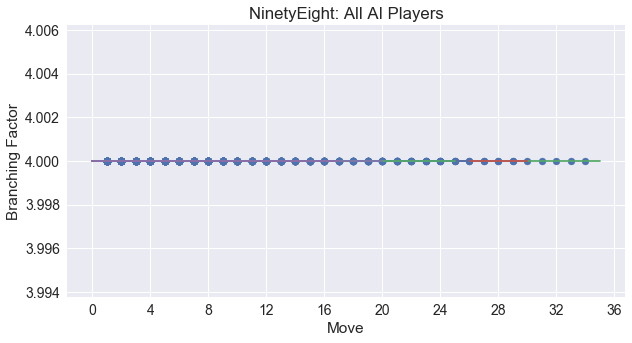

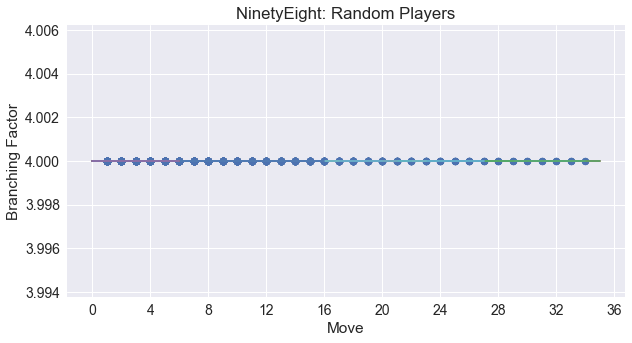

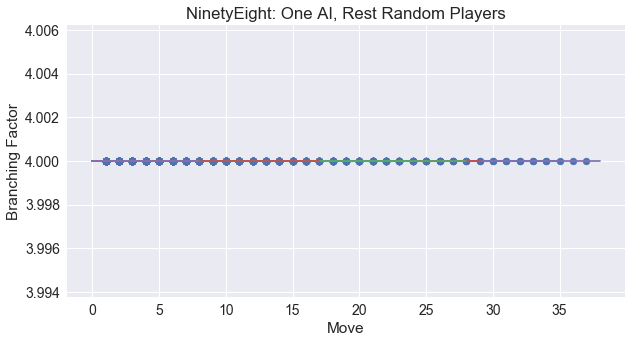

In [5]:
for type in count.keys():
    fopen = open("../CardStockXam/bin/Release/games/" + game + str(4) + ".gdl" + type + "-choicestats.txt")
    data = fopen.readlines()
    fopen.close()
    nump = 4
    alldata = []
    allmoves = []
    heuristics["Convergence"] = 0
    ax = plt.figure(figsize=(10,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("Move")
    plt.ylabel("Branching Factor")
    plt.title(game + ": " + typename[type])
    
    for i in range(2, len(data[1:302]), 3):
        choices = [int(x) for x in data[i][:-2].strip().split(",")]
        slope, intercept, r_value, p_value, std_error = st.linregress(range(1, len(choices) + 1), choices)
        heuristics["Convergence"] += (1 - (slope / 2 + 0.5)) / count[type]
        allmoves += choices
        alldata += range(1, len(choices) + 1)
        interps = np.linspace(0, len(choices) + 1, 200)
        plt.plot(interps, intercept + slope * interps)

    plt.scatter(alldata, allmoves)
print(type, convergence)


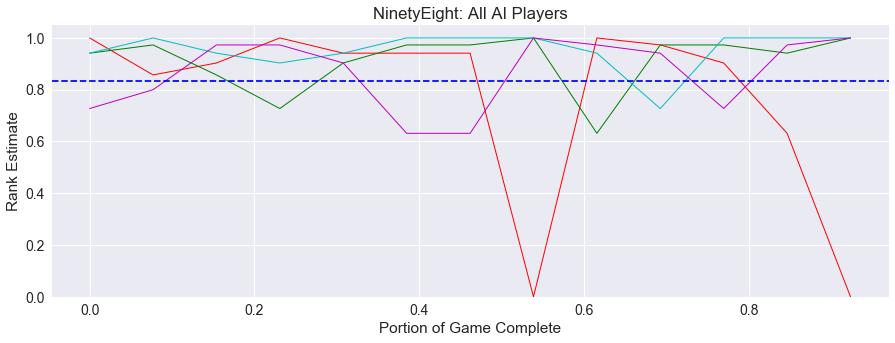

In [29]:
nump = 4
dthresh = (1 + (nump - 2) / (nump - 1)) / 2
colors = ["r", "g", "c", "m", "y"]
heuristics["Drama"] = 0
heuristics["Security"] = 0
for type in ["AllAI"]:
    fopen = open("../CardStockXam/bin/Release/games/" + game + str(nump) + ".gdl" + type + "-leadstats.txt")
    data = fopen.readlines()
    fopen.close()
    preds = [[], [], [], [], []]
    ax = plt.figure(figsize=(15,5)).gca()
#    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(game + ": " + typename[type])
    plt.xlabel("Portion of Game Complete")
    plt.ylabel("Rank Estimate")
    plt.ylim(0, 1.05)
    count2 = 0
    for d in data[2:]:
        if not d[0].isdigit():

            maxlen = 0
            for p in preds:
                if len(p) > maxlen:
                    maxlen = len(p)
                    
            winner = 0
            winscore = 0
            for i in range(len(preds)):
                if len(preds[i]) > 0 and preds[i][-1] > winscore:
                    winner = i
                    winscore = preds[i][-1]

            #colors = ["k", "k", "k", "k", "k"]
            #colors[winner] = "r"        
            dcount = 0
            drama = 0
            for s in preds[winner]:
                if s < dthresh:
                    dcount += 1
                    drama += (dthresh - s) ** 0.5
            if dcount > 0:
                drama /= dcount
            heuristics["Drama"] += drama / count[type]
            heuristics["Security"] += (1 - dcount /  len(preds[winner])) / count[type]
            #print(count2, 1 - (dcount / len(preds[winner])))

            if count2 == 10:
                c = 0 
                plt.plot([x / maxlen for x in range(len(preds[0]))], preds[0], color=colors[c], alpha=1, linewidth=1.0)
                for plist in preds[1:]:
                    c += 1
                    plt.plot([x / maxlen for x in range(len(plist))], plist, color=colors[c], alpha=1, linewidth=1.0)
                    pass
                plt.axhline(dthresh, color="b", ls="dashed")
            preds = [[], [], [], [], []]
            count2 += 1
        else:
            leads = [float(x) for x in d[:-2].strip().split(",")]
            for p in range(nump):
                preds[p].append(leads[p + 1])


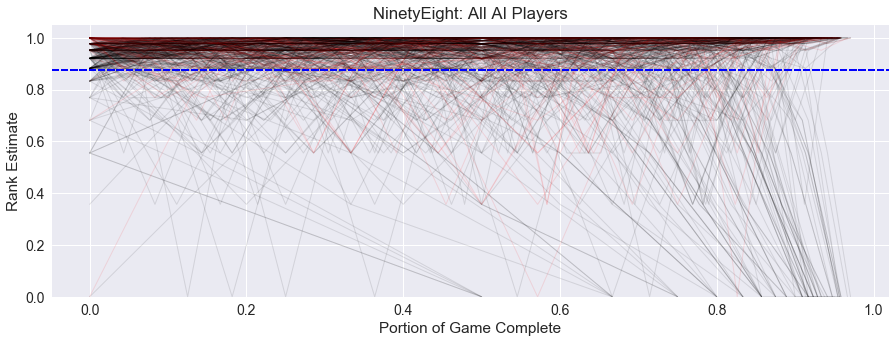

In [7]:
nump = 5
dthresh = (1 + (nump - 2) / (nump - 1)) / 2
colors = ["r", "g", "c", "m", "y"]
heuristics["Drama"] = 0
heuristics["Security"] = 0
for type in ["AllAI"]:
    fopen = open("../CardStockXam/bin/Release/games/" + game + str(nump) + ".gdl" + type + "-leadstats.txt")
    data = fopen.readlines()
    fopen.close()
    preds = [[], [], [], [], []]
    ax = plt.figure(figsize=(15,5)).gca()
#    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(game + ": " + typename[type])
    plt.xlabel("Portion of Game Complete")
    plt.ylabel("Rank Estimate")
    plt.ylim(0, 1.05)
    count2 = 0
    for d in data[2:]:
        if not d[0].isdigit():

            maxlen = 0
            for p in preds:
                if len(p) > maxlen:
                    maxlen = len(p)
                    
            winner = 0
            winscore = 0
            for i in range(len(preds)):
                if len(preds[i]) > 0 and preds[i][-1] > winscore:
                    winner = i
                    winscore = preds[i][-1]

            colors = ["k", "k", "k", "k", "k"]
            colors[winner] = "r"        
            dcount = 0
            drama = 0
            for s in preds[winner]:
                if s < dthresh:
                    dcount += 1
                    drama += (dthresh - s) ** 0.5
            if dcount > 0:
                drama /= dcount
            heuristics["Drama"] += drama / count[type]
            heuristics["Security"] += (1 - dcount /  len(preds[winner])) / count[type]
            #print(count2, 1 - (dcount / len(preds[winner])))

            if count2 >= 0:
                c = 0 
                plt.plot([x / maxlen for x in range(len(preds[0]))], preds[0], color=colors[c], alpha=.1, linewidth=1.0)
                for plist in preds[1:]:
                    c += 1
                    plt.plot([x / maxlen for x in range(len(plist))], plist, color=colors[c], alpha=.1, linewidth=1.0)
                    pass
                plt.axhline(dthresh, color="b", ls="dashed")
            preds = [[], [], [], [], []]
            count2 += 1
        else:
            leads = [float(x) for x in d[:-2].strip().split(",")]
            for p in range(nump):
                preds[p].append(leads[p + 1])


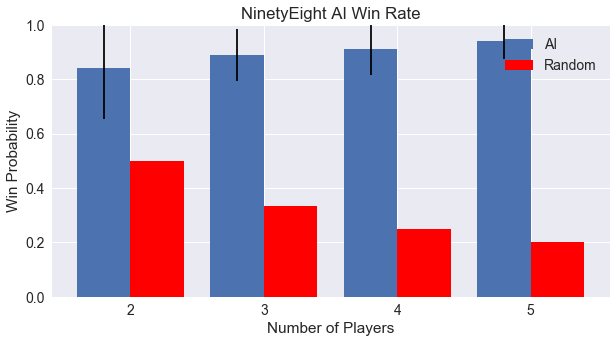

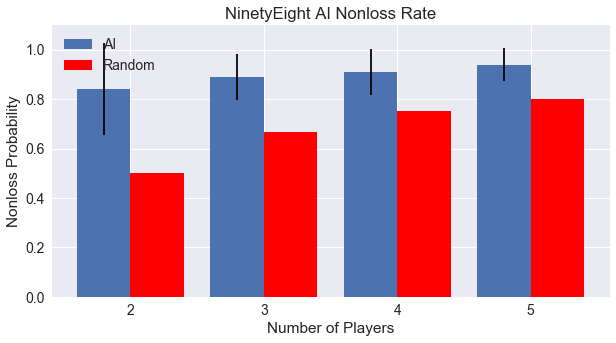

In [8]:
type = "RndandAI"
w = 0.4
fpw = []
fpwerr = []
nl = []
nlerr = []
for nump in range(2, 6):
    fopen = open("../CardStockXam/bin/Release/games/" + game + str(nump) + ".gdl" + type + "-resultsstats.txt")
    data = fopen.readlines()
    fopen.close()
    score = []
    rank = []
    ranks = []
    allrank = []
    for i in range(nump):
        scores = [int(x) for x in data[4 + i][:-2].strip().split(",")]
        score.append(sum(scores) / count[type])
        ranks.append([int(x) for x in data[4 + nump + 1 + i][:-2].strip().split(",")])
        allrank.extend(ranks[i])
        rank.append(sum(ranks[i]) / count[type])
    maxr = np.max(allrank)
    fpw.append(len([x for x in ranks[0] if x == 0]) / count[type])
    nl.append(len([x for x in ranks[0] if x != maxr]) / count[type])

    vals = []
    v2 = []
    for j in range(epoch):
        x = len([x for x in ranks[0][epoch*j:epoch*(j+1)] if x == 0]) / (count[type]/epoch)
        vals.append(x)
        y = len([x for x in ranks[0][epoch*j:epoch*(j+1)] if x != maxr]) / (count[type]/epoch)
        v2.append(y)
    fpwerr.append(np.std(vals))
    nlerr.append(np.std(v2))

expected = [1 / x for x in range(2, len(fpw) + 2)]
ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(0, 1)
plt.bar([x - w/2 for x in range(2, len(fpw) + 2)], fpw, width=w)
plt.bar([x + w/2 for x in range(2, len(fpw) + 2)], expected, width=w, color="r")
plt.errorbar([x - w/2 for x in range(2, len(fpw) + 2)], fpw, yerr=fpwerr, fmt='none', capsize=4, color="k")
plt.xlabel("Number of Players")
plt.ylabel("Win Probability")
plt.legend(["AI", "Random"], loc=1)
plt.title(game + " AI Win Rate")

expected = [(x - 1) / x for x in range(2, len(fpw) + 2)]
ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(0, 1.1)
plt.bar([x - w/2 for x in range(2, len(fpw) + 2)], nl, width=w)
plt.bar([x + w/2 for x in range(2, len(fpw) + 2)], expected, width=w, color="r")
plt.errorbar([x - w/2 for x in range(2, len(fpw) + 2)], nl, yerr=nlerr, fmt='none', capsize=4, color="k")
plt.xlabel("Number of Players")
plt.ylabel("Nonloss Probability")
plt.title(game + " AI Nonloss Rate")
plt.legend(["AI", "Random"])

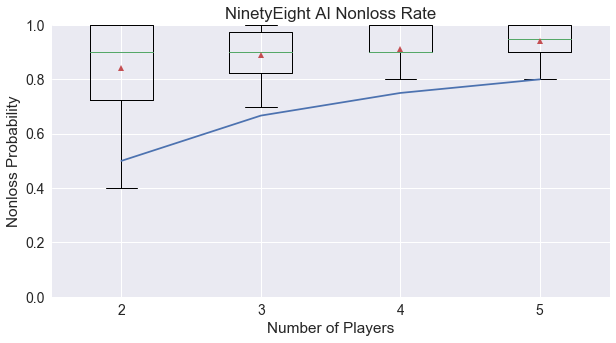

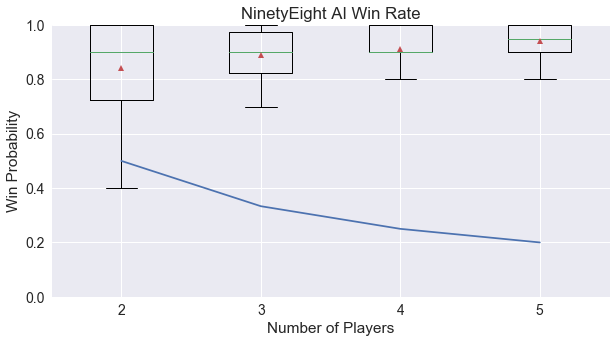

In [9]:
type = "RndandAI"
w = 0.4
fpw = []
fpwerr = []
nl = []
nlerr = []
vals2 = []
wvals = []
for nump in range(2, 6):
    fopen = open("../CardStockXam/bin/Release/games/" + game + str(nump) + ".gdl" + type + "-resultsstats.txt")
    data = fopen.readlines()
    fopen.close()
    score = []
    rank = []
    ranks = []
    allrank = []
    for i in range(nump):
        scores = [int(x) for x in data[4 + i][:-2].strip().split(",")]
        score.append(sum(scores) / count[type])
        ranks.append([int(x) for x in data[4 + nump + 1 + i][:-2].strip().split(",")])
        allrank.extend(ranks[i])
        rank.append(sum(ranks[i]) / count[type])
    maxr = np.max(allrank)
    fpw.append(len([x for x in ranks[0] if x == 0]) / count[type])
    nl.append(len([x for x in ranks[0] if x != maxr]) / count[type])

    vals = []
    v2 = []
    for j in range(epoch):
        x = len([x for x in ranks[0][epoch*j:epoch*(j+1)] if x == 0]) / (count[type]/epoch)
        vals.append(x)
        y = len([x for x in ranks[0][epoch*j:epoch*(j+1)] if x != maxr]) / (count[type]/epoch)
        v2.append(y)
    fpwerr.append(np.std(vals))
    nlerr.append(np.std(v2))
    wvals.append(vals)
    vals2.append(v2)

ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(0, 1)
plt.boxplot(vals2, labels=[2, 3, 4, 5], showmeans=True)
plt.plot(range(1, 5), [(x - 1) / x for x in range(2, len(fpw) + 2)])
plt.xlabel("Number of Players")
plt.ylabel("Nonloss Probability")
plt.title(game + " AI Nonloss Rate")

ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(0, 1)
plt.boxplot(wvals, labels=[2, 3, 4, 5], showmeans=True)
plt.plot(range(1, 5), [1 / x for x in range(2, len(fpw) + 2)])
plt.xlabel("Number of Players")
plt.ylabel("Win Probability")
plt.title(game + " AI Win Rate")

11.479999999999997
12.699999999999998
12.450000000000003
12.049999999999999
10.619999999999996
11.139999999999995
11.899999999999993
12.359999999999998
12.42
14.050000000000002
10.659999999999997
11.150000000000002


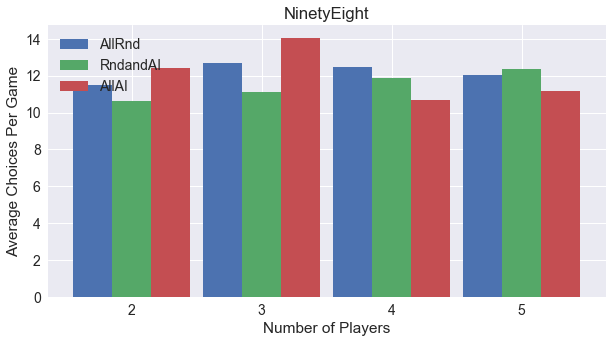

In [10]:
w = 0.3
plt.figure(figsize=(10,5))
avechoices = {}
ac = -1
for type in ["AllRnd", "RndandAI", "AllAI"]:
    avechoices[type] = []
    for nump in range(2, 6):
        fopen = open("../CardStockXam/bin/Release/games/" + game + str(nump) + ".gdl" + type + "-choicestats.txt")
        data = fopen.readlines()
        fopen.close()
        ave = 0
        for i in range(2, len(data[1:302]), 3):
            choices = [int(x) for x in data[i][:-2].strip().split(",")]
            #print(len(choices))
            ave += len(choices) / count[type]
        print(ave)
        avechoices[type].append(ave)
    plt.bar([x + (ac * w) for x in range(2, 6)], avechoices[type], width=w)
    plt.xticks(range(2, 6), range(2, 6))
    ac += 1
plt.title(game)
plt.ylabel("Average Choices Per Game")
plt.xlabel("Number of Players")
plt.legend(["AllRnd", "RndandAI", "AllAI"], loc=2)

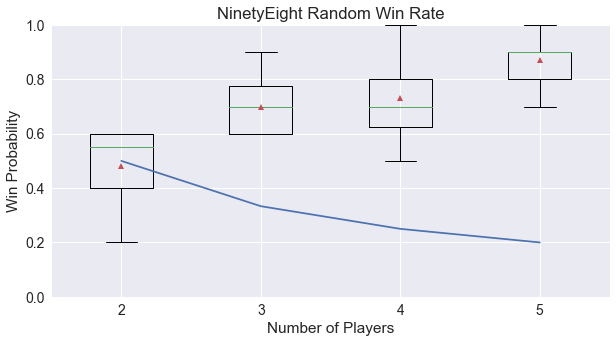

In [11]:
type = "AllRnd"
w = 0.4
fpw = []
fpwerr = []
nl = []
nlerr = []
wvals = []

for nump in range(2, 6):
    fopen = open("../CardStockXam/bin/Release/games/" + game + str(nump) + ".gdl" + type + "-resultsstats.txt")
    data = fopen.readlines()
    fopen.close()
    score = []
    rank = []
    ranks = []
    allrank = []
    for i in range(nump):
        scores = [int(x) for x in data[4 + i][:-2].strip().split(",")]
        score.append(sum(scores) / count[type])
        ranks.append([int(x) for x in data[4 + nump + 1 + i][:-2].strip().split(",")])
        allrank.extend(ranks[i])
        rank.append(sum(ranks[i]) / count[type])
    maxr = np.max(allrank)
    fpw.append(len([x for x in ranks[0] if x == 0]) / count[type])
    nl.append(len([x for x in ranks[0] if x != maxr]) / count[type])

    vals = []
    v2 = []
    for j in range(epoch):
        x = len([x for x in ranks[0][epoch*j:epoch*(j+1)] if x == 0]) / (count[type]/epoch)
        vals.append(x)
        y = len([x for x in ranks[0][epoch*j:epoch*(j+1)] if x != maxr]) / (count[type]/epoch)
        v2.append(y)
    fpwerr.append(np.std(vals))
    nlerr.append(np.std(v2))
    wvals.append(vals)

expected = [1 / x for x in range(2, len(fpw) + 2)]
ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(0, 1)
plt.boxplot(wvals, labels=[2, 3, 4, 5], showmeans=True)
plt.plot(range(1, 5), expected)
plt.xlabel("Number of Players")
plt.ylabel("Win Probability")
plt.title(game + " Random Win Rate")

In [12]:
fpwerr

[0.13999999999999999,
 0.10000000000000003,
 0.14177446878757827,
 0.089999999999999997]

In [13]:
rank

[0.52, 0.68, 1.04, 0.8, 0.96]

{'Convergence': 0.50000000000000033, 'Drama': 0.26319269762522957, 'Security': 0.9113085579916412, 'Fairness': 0.978125, 'MeaningfulMoves': 0.283283509222205}


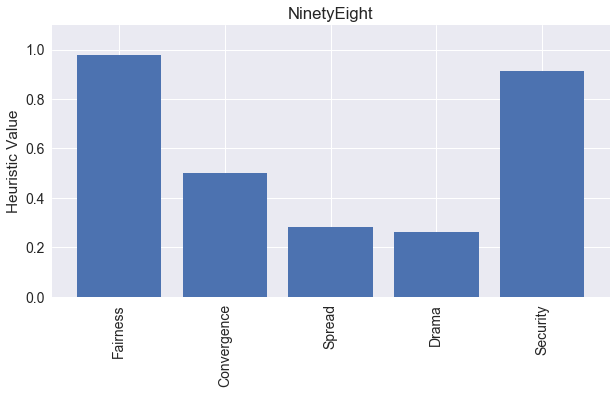

In [14]:
fopen = open("../CardStockXam/bin/Release/games/" + game + str(nump) + ".gdl-heuristics.txt")
data = fopen.readlines()
fopen.close()
names = []
values = []
for line in data:
    h = line.strip().split("\t")
    names.append(h[0])
    values.append(float(h[1]))
    if (names[-1] in ["MeaningfulMoves", "Fairness"]):
        heuristics[names[-1]] = values[-1]
plt.figure(figsize=(10,5))
newnames = ["Fairness", "Convergence", "Spread", "Drama", "Security"]
newvalues = []
for n in newnames:
    if n == "Spread":
        newvalues.append(heuristics["MeaningfulMoves"])
    else:
        newvalues.append(heuristics[n])
plt.bar(range(len(heuristics)), newvalues)
plt.xticks(range(len(heuristics)), newnames, rotation="vertical")
plt.title(game)
plt.ylabel("Heuristic Value")
plt.ylim(0, 1.1)
print(heuristics)


(0, 1)

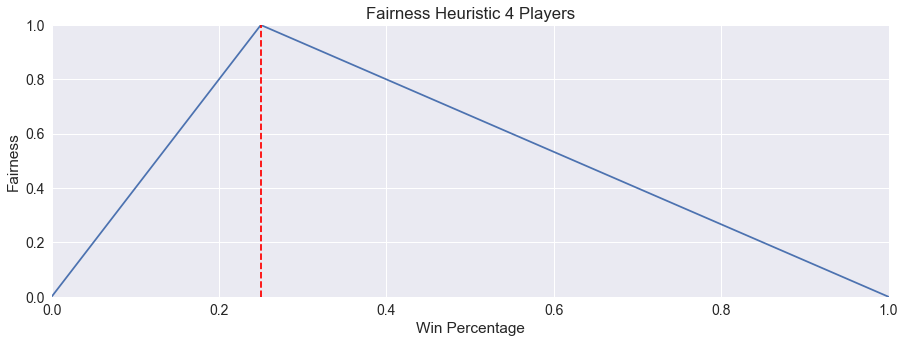

In [15]:
xs = [0, .25, 1]
ys = [0, 1, 0]
ax = plt.figure(figsize=(15,5)).gca()
plt.plot(xs, ys)
plt.title("Fairness Heuristic 4 Players")
plt.ylabel("Fairness")
plt.xlabel("Win Percentage")
plt.axvline(x=0.25, color="r", ls="dashed")
plt.ylim(0, 1)
plt.xlim(0, 1)

(1, 6.5)

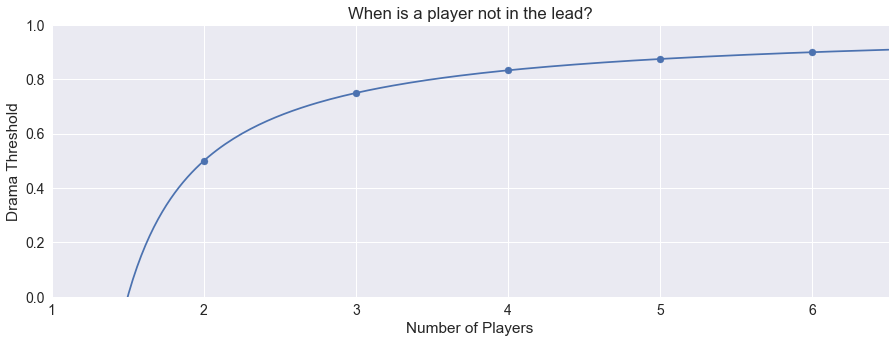

In [16]:
xs = np.linspace(1.01, 6.5, 200)
ys = [(1 + (x - 2) / (x - 1)) / 2 for x in xs]
xss = np.arange(2, 7)
yss = [(1 + (x - 2) / (x - 1)) / 2 for x in xss]
ax = plt.figure(figsize=(15,5)).gca()
plt.plot(xs, ys)
plt.scatter(xss, yss)
plt.title("When is a player not in the lead?")
plt.ylabel("Drama Threshold")
plt.xlabel("Number of Players")
plt.ylim(0, 1)
plt.xlim(1, 6.5)

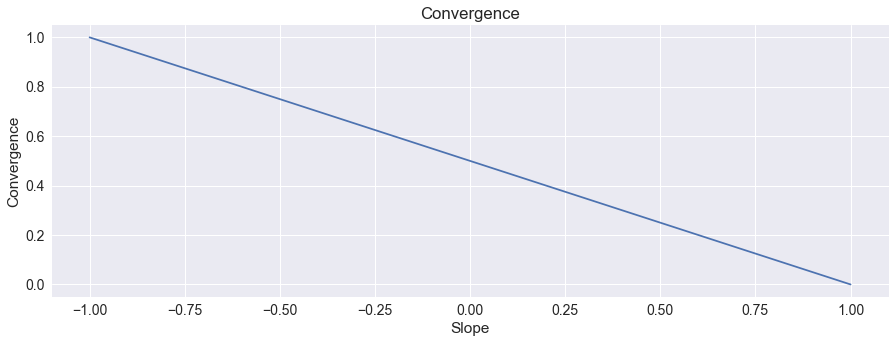

In [17]:
xs = np.linspace(-1, 1, 200)
ys = [(1 - (x / 2 + 0.5)) for x in xs]
ax = plt.figure(figsize=(15,5)).gca()
plt.plot(xs, ys)
plt.title("Convergence")
plt.ylabel("Convergence")
plt.xlabel("Slope")
